<a href="https://colab.research.google.com/github/Sakshamgoel/homocomp/blob/main/homocomp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-bio
!pip install scipy
!pip install pyabpoa
!pip install plotnine

In [2]:
import numpy as np
import pyabpoa as pa
from skbio.alignment import global_pairwise_align_nucleotide
from skbio import TabularMSA, DNA
import statistics

import pandas as pd

import matplotlib.pyplot as plt
from plotnine import *
from plotnine.data import *

In [3]:
# Generates a random sequence of basepairs of length 'n'
def generate_sequence(n):
    return("".join(np.random.choice(["A","C","G","T"], n)))

# Mutates the string to introduce mismatches and indels
def mutate(str, snp_rate = 0.1, indel_rate = 0.1):
    x = [c for c in str]
    i = 0
    while i < len(x):
        if np.random.random() < snp_rate:
            x[i] = generate_sequence(1)
        if np.random.random() < indel_rate:
            length = np.random.geometric(0.5)
            if np.random.random() < 0.5: # insertion
                x[i] = x[i] + generate_sequence(length)
            else:
                for j in range(i,i+length):
                    if j < len(x):
                        x[j] = ""
                        i += 1
        i += 1
    return("".join(x))

In [4]:
'''
Function to compress a given sequence string into individual unique BasePairs and their corresponding frequencies
@param sequence: string of a dna sequence
@return tuple:
   - Index 0: list of individual base pairs
   - Index 1: list of corresponding frequencies of the base pairs
'''
def homoCompress(sequence):
  # Compressed Sequence string that stores individual unique base pairs
  compressedSequence = ''
  # List that stores corresponding frequencies
  frequencies = []

  # For each character:
  #   if it is not seen before, append it to the basePairs list and set its frequency to 1
  #   else if it is seen before, just append its frequency by 1
  currentChar = None
  for char in sequence:
    if not currentChar or currentChar != char:
      currentChar = char
      compressedSequence += currentChar
      frequencies.append(1)
    else:
      frequencies[len(frequencies) - 1] += 1

  return(compressedSequence, frequencies)

In [5]:
'''
Function that returns compressed sequences
@param sequences: list of uncompressed sequences
@return list of compressed sequences
'''
def compressSequences(sequences):
  compressedSequences = []
  compressedSequenceFrequencies = []
    
  for sequence in sequences:
      homoCompressTuple = homoCompress(sequence)
      compressedSequences.append(homoCompressTuple[0])
      compressedSequenceFrequencies.append(homoCompressTuple[1])
  return(compressedSequences, compressedSequenceFrequencies)

In [6]:
'''
Function to get the consensus sequence from a list of sequences
@param sequences: list of string of individual sequences
@return string of consensus sequence
'''
def partialOrderAlignment(sequences):    
    msaAlignerObject = pa.msa_aligner()

    # perform multiple sequence alignment
    # generate a figure of alignment graph to pog.png
    multipleSequenceAlignment = msaAlignerObject.msa(sequences, out_cons=True, out_msa=True, out_pog='pog.png', incr_fn='') 

    return(multipleSequenceAlignment.cons_seq[0])

In [7]:
'''
Global Alignment function

@param sequence1: string first sequence to align
@param sequence2: string second sequence to align

Penalty scores:-
- Mismatch: -1
- Match: 1
- Indel: -2

For backtrace:-
- First Element: -1
- Diagonal: 0
- Left: 1
- Up: 2

@return: a tuple the global alignment of both the sequences and the alignment score
'''
def globalAlignment(sequence1, sequence2):
  # Penalty values
  indel = -2
  mismatch = -1
  match = 1
  
  # Matrix initialization
  m = len(sequence1)
  n = len(sequence2)
  matrix = [[0 for i in range(n + 1)] for j in range(m + 1)]
  backtrace = [[0 for i in range(n + 1)] for j in range(m + 1)]

  # Initializing first row and first column to indel values
  for i in range(m + 1):
    matrix[i][0] = i * indel
    backtrace[i][0] = 2
  for j in range(n + 1):
    matrix[0][j] = j * indel
    backtrace[0][j] = 1
  backtrace[0][0] = -1

  # The actual dp
  for i in range(1, m + 1):
    for j in range(1, n + 1):
      if sequence1[i - 1] == sequence2[j - 1]:        # match
        matrix[i][j] = matrix[i - 1][j - 1] + match
      else:                                           # mismatch
        matrix[i][j] = matrix[i - 1][j - 1] + mismatch

      if matrix[i][j] < (matrix[i][j - 1] + indel):   # indel
        matrix[i][j] = matrix[i][j - 1] + indel
        backtrace[i][j] = 1
      elif matrix[i][j] < (matrix[i - 1][j] + indel): # indel
         matrix[i][j] = (matrix[i - 1][j] + indel)
         backtrace[i][j] = 2
  
  alignmentScore = matrix[m][n] 

  # Viterbi BackTrace
  currRow = m
  currCol = n

  alignedSequence1 = ''
  alignedSequence2 = ''

  while backtrace[currRow][currCol] != -1:
    if backtrace[currRow][currCol] == 0:
      alignedSequence1 += sequence1[currRow - 1]
      alignedSequence2 += sequence2[currCol - 1]
      currRow -= 1
      currCol -= 1
    elif backtrace[currRow][currCol] == 1:
      alignedSequence1 += '-'
      alignedSequence2 += sequence2[currCol - 1]
      currCol -= 1
    elif backtrace[currRow][currCol] == 2:
      alignedSequence1 += sequence1[currRow - 1]
      alignedSequence2 += '-'
      currRow -= 1

  # Reversing the aligned strings as they are the reverse of true alignment because of backtracing
  alignedSequence1 = alignedSequence1[::-1]
  alignedSequence2 = alignedSequence2[::-1]

  return (alignedSequence1, alignedSequence2, alignmentScore)

In [8]:
'''
Pairwise Alignment Function
@param sequences: a list of string sequences that derive from the consensus sequence
@param consensusSequence: the consensusSequence obtained from partial order alignment

@return alignedSequences: a list of tuples, where:
  Index 0: Pairwise alignment of the consensus sequence
  Index 1: Pairwise alignment of the sequence
  Index 2: Alignment score of this specific Pairwise Alignment
'''
def pairwiseAlignment(sequences, consensusSequence):
  alignedSequences = []
  for sequence in sequences:
    alignment = globalAlignment(consensusSequence, sequence)
    alignedSequences.append(alignment)
  return alignedSequences

In [9]:
'''
Expand Consensus Sequence using Mean, Median, or mode

This function expands the compressed consensus sequence by using one of the metric mentioned above
and compares the specific base pair in the consensus sequence's location to the one associated in the different
compressed sequences

@param alignedSequences: the list of tuples of aligned sequences where:
                                    - Index 0 is the consensus sequence part of the alignment
                                    - Index 1 is the regular sequence part of the alignment
@param compressedSequenceFrequences: the list of unique base pair frequencies for each of the sequences aligned
@param consensusSequence: the string of compressed consensus sequence obtained
@param metric: an int referring to the metric to be used for computation of expanded consensus sequence
                                    - 0 for mean (default)
                                    - 1 for median
                                    - 2 for mode
'''

def expandConsensus(alignedSequences, compressedSequenceFrequencies, consensusSequence, metric = 0):
  arr = []
  for alignment in alignedSequences:
    alignPointerArr = []
    
    alignedConsensus = alignment[0]
    normalSequence = alignment[1]

    alignPointer = 0

    for i in range(len(alignedConsensus)):
      if alignedConsensus[i] == '-':
        alignPointer += 1
      elif normalSequence[i] == '-':
        alignPointerArr.append(-1)
      elif alignedConsensus[i] == normalSequence[i]:
        alignPointerArr.append(alignPointer)
        alignPointer += 1
      else:
        alignPointerArr.append(-1)
        alignPointer += 1

    arr.append(alignPointerArr)

  expandedConsensus = ""

  for i in range(len(consensusSequence)):
    countArray = []

    for (j, alignment) in enumerate(alignedSequences):
      if arr[j][i] != -1:
        countArray.append(compressedSequenceFrequencies[j][arr[j][i]])
    
    snippetLength = 0
    if len(countArray) > 0:
      if metric == 0:
        snippetLength = round(statistics.mean(countArray))
      elif metric == 1:
        snippetLength = int(statistics.median(countArray))
      else:
        snippetLength = int(statistics.mode(countArray))

    for k in range(snippetLength):
      expandedConsensus += consensusSequence[i]
  return expandedConsensus


In [10]:
'''
Function to calculate score of the expanded HomoComp consensus Sequence
We globally align the expanded consensus sequence to every mutation sequence and get the average score of it
'''
def calculateScore(sequences, expandedConsensusSequence):
  num = 0
  for sequence in sequences:
    alignment = globalAlignment(sequence, expandedConsensusSequence)
    num += alignment[2]
  return num / len(sequences)

In [11]:
'''
Function that runs a single iteration of the entire simulation

@param iterationCount: the number of iterations we run the algorithm for
@param mutatedSequenceCount: the number of mutated sequences that will be generated
@param sequenceLength: the length of the base Sequence that will be generated

@return result: a dictionary with following keys:-
                - 'uncompressedConsensus': a dictionary with following key and values:-
                                          - 'sequence': string value of the uncompressed consensus sequence found
                                          - 'score': decimal value of the score of consensus sequence
                - 'meanConsensus': a dictionary with following key and values:-
                                          - 'sequence': string value of the mean consensus sequence found
                                          - 'score': decimal value of the score of consensus sequence
                - 'medianConsensus': a dictionary with following key and values:-
                                          - 'sequence': string value of the median consensus sequence found
                                          - 'score': decimal value of the score of consensus sequence
                - 'modeConsensus': a dictionary with following key and values:-
                                          - 'sequence': string value of the mode consensus sequence found
                                          - 'score': decimal value of the score of consensus sequence
'''
def singleIteration(mutatedSequenceCount = 10, sequenceLength = 100):

  baseSequence = generate_sequence(sequenceLength)
  
  sequences = []
  for i in range(mutatedSequenceCount):
    tempSequence = mutate(baseSequence)
    sequences.append(tempSequence)
  
  uncompressedConsensusSequence = partialOrderAlignment(sequences)

  compressedSequencesTuple = compressSequences(sequences)

  compressedSequences = compressedSequencesTuple[0]
  compressedSequenceFrequencies = compressedSequencesTuple[1]
  
  compressedConsensusSequence = partialOrderAlignment(compressedSequences)
  alignedSequences = pairwiseAlignment(compressedSequences, compressedConsensusSequence)
  expandedConsensusSequenceUsingMean = expandConsensus(alignedSequences, compressedSequenceFrequencies, compressedConsensusSequence, 0)
  expandedConsensusSequenceUsingMedian = expandConsensus(alignedSequences, compressedSequenceFrequencies, compressedConsensusSequence, 1)
  expandedConsensusSequenceUsingMode = expandConsensus(alignedSequences, compressedSequenceFrequencies, compressedConsensusSequence, 2)

  uncompressedConsensusScore = calculateScore(sequences, uncompressedConsensusSequence)

  meanConsensusScore = calculateScore(sequences, expandedConsensusSequenceUsingMean)
  medianConsensusScore = calculateScore(sequences, expandedConsensusSequenceUsingMedian)
  modeConsensusScore = calculateScore(sequences, expandedConsensusSequenceUsingMode)

  result = {}

  result['uncompressedConsensus'] = {'sequence': uncompressedConsensusSequence, 'score': uncompressedConsensusScore}
  result['meanConsensus'] = {'sequence': expandedConsensusSequenceUsingMean, 'score': meanConsensusScore}
  result['medianConsensus'] = {'sequence': expandedConsensusSequenceUsingMedian, 'score': medianConsensusScore}
  result['modeConsensus'] = {'sequence': expandedConsensusSequenceUsingMode, 'score': modeConsensusScore}

  return result  

In [19]:
def main():

  uncompressedScore = 0
  meanScore = 0
  medianScore = 0
  modeScore = 0

  iterations = 10
  for i in range(iterations):

    result = singleIteration()

    uncompressedScore += result['uncompressedConsensus']['score']
    meanScore += result['meanConsensus']['score']
    medianScore += result['medianConsensus']['score']
    modeScore += result['modeConsensus']['score']

    # print('Uncompressed Consensus Sequence: ', result['uncompressedConsensus']['sequence'])
    # print('Uncompressed Consensus Sequence score: ', uncompressedScore)

    # print('Mean Consensus Sequence: ', result['meanConsensus']['sequence'])
    # print('Mean Consensus Sequence score: ', meanScore)

    # print('Median Consensus Sequence: ', result['medianConsensus']['sequence'])
    # print('Median Consensus Sequence score: ', medianScore)

    # print('Mode Consensus Sequence: ', result['modeConsensus']['sequence'])
    # print('Mode Consensus Sequence score: ', modeScore)

  uncompressedScore = uncompressedScore / iterations
  meanScore = meanScore / iterations
  medianScore = medianScore / iterations
  modeScore = modeScore / iterations

  x = ['Uncompressed', 'Mean Expanded', 'Median Expanded', 'Mode Expanded']
  y = [uncompressedScore, meanScore, medianScore, modeScore]

  df = pd.DataFrame({'x': x, 'y': y})

  plotTitle = str(iterations) + ' Iteration Results'

  plot = ggplot(df, aes(x = 'x', y='y', fill = x)) + \
    geom_bar(stat='identity') + \
    ggtitle(plotTitle) + \
    xlab('Mean, Median, and Mode variations of Homopolymer Compression v/s Regular POA') + \
    ylab('Score')

  print(plot)

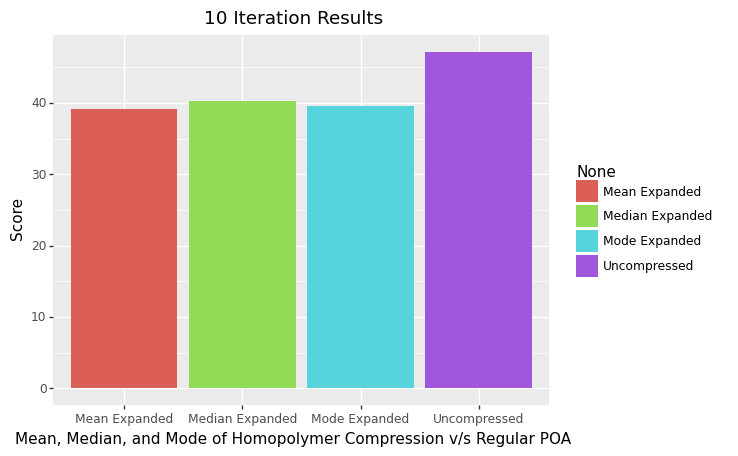

In [18]:
main()

In [14]:
# Everything below this point is testing

test_sequence = generate_sequence(10)
sequences = []

for i in range(10):
  sequences.append(mutate(test_sequence))

print(test_sequence)
for sequence in sequences:
  print(sequence)

CCGTCGCCTC
CCTTCGCCCTC
CCGCGCCTC
CTTCACC
CCGTCGCCACC
CGGTCGCCTCT
CCGTCACCTC
CCGTCGCTC
CGTCGCCTCTC
CCGTCGACTC
CCGTCCCTC


In [15]:
consensusSequence = partialOrderAlignment(sequences)

compressedSequences = compressSequences(sequences)
compressedConsensusSequence = partialOrderAlignment(compressedSequences[0])

print('Consensus sequence:\t\t', consensusSequence)
print('Compressed Consensus sequence:\t', compressedConsensusSequence)

Consensus sequence:		 CCGTCGCCCTC
Compressed Consensus sequence:	 CGTCGCTC


In [16]:
alignedSequences = pairwiseAlignment(compressedSequences[0], compressedConsensusSequence)

for (i, obj) in enumerate(alignedSequences):
  print('Sequence', i, ': \t\t', obj[0])
  print('Consensus Sequence: \t', obj[1])
  print('Score: ', obj[2])

Sequence 0 : 		 CGTCGCTC
Consensus Sequence: 	 C-TCGCTC
Score:  5
Sequence 1 : 		 CGTCGCTC
Consensus Sequence: 	 CG-CGCTC
Score:  5
Sequence 2 : 		 CGTCGCTC
Consensus Sequence: 	 C-T--CAC
Score:  -3
Sequence 3 : 		 CGTCGCTC
Consensus Sequence: 	 CGTCGCAC
Score:  6
Sequence 4 : 		 CGTCGCTC-
Consensus Sequence: 	 CGTCGCTCT
Score:  6
Sequence 5 : 		 CGTCGCTC
Consensus Sequence: 	 CGTCACTC
Score:  6
Sequence 6 : 		 CGTCGCTC
Consensus Sequence: 	 CGTCGCTC
Score:  8
Sequence 7 : 		 CGTCG--CTC
Consensus Sequence: 	 CGTCGCTCTC
Score:  4
Sequence 8 : 		 CGTCG-CTC
Consensus Sequence: 	 CGTCGACTC
Score:  6
Sequence 9 : 		 CGTCGCTC
Consensus Sequence: 	 CGT--CTC
Score:  2
